In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import shutil
import os
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle

In [3]:
shutil.copytree('drive/MyDrive/JHU_Courses/Deep_Learning/Project/frames_1fps_resize_zip', 'frames_1fps_resize_zip')

'frames_1fps_resize_zip'

In [4]:
cd frames_1fps_resize_zip

/content/frames_1fps_resize_zip


In [5]:
!unzip frames-1fps-resize.zip

Streaming output truncated to the last 5000 lines.
  inflating: frames-1fps-resize/video79/video79-1123.jpg  
  inflating: frames-1fps-resize/video79/video79-1124.jpg  
  inflating: frames-1fps-resize/video79/video79-1125.jpg  
  inflating: frames-1fps-resize/video79/video79-1126.jpg  
  inflating: frames-1fps-resize/video79/video79-1127.jpg  
  inflating: frames-1fps-resize/video79/video79-1128.jpg  
  inflating: frames-1fps-resize/video79/video79-1129.jpg  
  inflating: frames-1fps-resize/video79/video79-113.jpg  
  inflating: frames-1fps-resize/video79/video79-1130.jpg  
  inflating: frames-1fps-resize/video79/video79-1131.jpg  
  inflating: frames-1fps-resize/video79/video79-1132.jpg  
  inflating: frames-1fps-resize/video79/video79-1133.jpg  
  inflating: frames-1fps-resize/video79/video79-1134.jpg  
  inflating: frames-1fps-resize/video79/video79-1135.jpg  
  inflating: frames-1fps-resize/video79/video79-1136.jpg  
  inflating: frames-1fps-resize/video79/video79-1137.jpg  
  infl

In [6]:
cd ..

/content


In [7]:
project_path = "drive/MyDrive/JHU_Courses/Deep_Learning/Project"

In [8]:
# get paths and labels
img_dir = 'frames_1fps_resize_zip/frames-1fps-resize/'
tool_dir = project_path+'/Dataset/cholec80/tool_annotations'
phase_dir = project_path+'/Dataset/cholec80/phase_annotations'

def get_dirs(root_dir):
    file_paths = []
    file_names = []
    for lists in os.listdir(root_dir):
        path = os.path.join(root_dir, lists)
        if os.path.isdir(path):
            file_paths.append(path)
            file_names.append(os.path.basename(path))
    file_names.sort()
    file_paths.sort()
    return file_names, file_paths

def get_files(root_dir):
    file_paths = []
    file_names = []
    for lists in os.listdir(root_dir):
        path = os.path.join(root_dir, lists)
        if not os.path.isdir(path):
            file_paths.append(path)
            file_names.append(os.path.basename(path))
    file_names.sort()
    file_paths.sort()
    return file_names, file_paths

img_dir_names, img_dir_paths = get_dirs(img_dir)
tool_file_names, tool_file_paths = get_files(tool_dir)
phase_file_names, phase_file_paths = get_files(phase_dir)

phase_dict = {}
phase_dict_key = ['Preparation', 'CalotTriangleDissection', 'ClippingCutting', 'GallbladderDissection', 'GallbladderPackaging', 'CleaningCoagulation', 'GallbladderRetraction']
for i in range(len(phase_dict_key)):
    phase_dict[phase_dict_key[i]] = i
print(phase_dict)

all_info_all = []

for j in range(len(tool_file_names)):
    last_tool_index = ''
    last_phase_index = ''
    tool_file = open(tool_file_paths[j])
    phase_file = open(phase_file_paths[j])
    tool_count = 0
    phase_count = 0
    info_all = []
    for tool_line in tool_file:
        tool_count += 1
        if tool_count > 1:
            tool_split = tool_line.split()
            info_each = []
            img_file_each_path = os.path.join(img_dir_paths[j], img_dir_names[j] + '-' + str(tool_count - 1) + '.jpg')
            info_each.append(img_file_each_path)
            for l in range(1, len(tool_split)):
                info_each.append(int(tool_split[l]))
                last_tool_index = tool_split[0]
            info_all.append(info_each)
            #print(info_each)
    for phase_line in phase_file:
        phase_count += 1
        if phase_count % 25 == 2 and (phase_count // 25) < len(info_all):
            phase_split = phase_line.split()
            info_all[phase_count // 25].append(phase_dict[phase_split[1]])
            # print(info_all[phase_count // 25])
            last_phase_index = phase_split[0]
    print('the{:4d}th tool: {:6d} index_error{:2d}'.format(j, tool_count - 1, int(last_tool_index) - int(last_phase_index)))

    #print(len(info_all))
    all_info_all.append(info_all)

with open('cholec80.pkl', 'wb') as f:
    pickle.dump(all_info_all, f)

with open('cholec80.pkl', 'rb') as f:
    all_info = pickle.load(f)

print(all_info[0][0])
print(all_info[79][0])

train_file_paths = []
test_file_paths = []
val_file_paths = []
val_labels = []
train_labels = []
test_labels = []

train_num_each = []
val_num_each = []
test_num_each = []

for i in range(32):
    train_num_each.append(len(all_info[i]))
    for j in range(len(all_info[i])):
        train_file_paths.append(all_info[i][j][0])
        train_labels.append(all_info[i][j][1:])

print(len(train_file_paths))
print(len(train_labels))

for i in range(32, 40):
    val_num_each.append(len(all_info[i]))
    for j in range(len(all_info[i])):
        val_file_paths.append(all_info[i][j][0])
        val_labels.append(all_info[i][j][1:])

print(len(val_file_paths))
print(len(val_labels))

for i in range(40, 80):
    test_num_each.append(len(all_info[i]))
    for j in range(len(all_info[i])):
        test_file_paths.append(all_info[i][j][0])
        test_labels.append(all_info[i][j][1:])

print(len(test_file_paths))
print(len(test_labels))

train_val_test_paths_labels = []
train_val_test_paths_labels.append(train_file_paths)
train_val_test_paths_labels.append(val_file_paths)
train_val_test_paths_labels.append(test_file_paths)

train_val_test_paths_labels.append(train_labels)
train_val_test_paths_labels.append(val_labels)
train_val_test_paths_labels.append(test_labels)

train_val_test_paths_labels.append(train_num_each)
train_val_test_paths_labels.append(val_num_each)
train_val_test_paths_labels.append(test_num_each)

with open('train_val_test_paths_labels.pkl', 'wb') as f:
    pickle.dump(train_val_test_paths_labels, f)

{'Preparation': 0, 'CalotTriangleDissection': 1, 'ClippingCutting': 2, 'GallbladderDissection': 3, 'GallbladderPackaging': 4, 'CleaningCoagulation': 5, 'GallbladderRetraction': 6}
the   0th tool:   1733 index_error 0
the   1th tool:   2839 index_error 0
the   2th tool:   5828 index_error 0
the   3th tool:   1522 index_error 0
the   4th tool:   2344 index_error 0
the   5th tool:   2153 index_error 0
the   6th tool:   4557 index_error 0
the   7th tool:   1519 index_error 0
the   8th tool:   2702 index_error 0
the   9th tool:   1749 index_error 0
the  10th tool:   3220 index_error 0
the  11th tool:   1090 index_error 0
the  12th tool:    981 index_error 0
the  13th tool:   1708 index_error 0
the  14th tool:   2058 index_error 0
the  15th tool:   2957 index_error 0
the  16th tool:   1304 index_error 0
the  17th tool:   1942 index_error 0
the  18th tool:   2424 index_error 0
the  19th tool:   1449 index_error 0
the  20th tool:   1258 index_error 0
the  21th tool:   1532 index_error 0
the  2

In [9]:
execfile(project_path+"/two_networks_two_tasks/utils.py")

In [10]:
execfile(project_path+"/two_networks_two_tasks/Model.py")

In [11]:
# param
train_batch_size = 40
val_batch_size = 8
test_batch_size = 8
workers = 2
learning_rate = 1e-3
epochs = 25

train_batch_size = 100
val_batch_size = 20
test_batch_size = 20
workers=mp.cpu_count()
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

alpha = 2 # KL cross loss ratio

cuda


In [12]:
# Load Data
train_dataset, train_num_each, val_dataset, val_num_each, test_dataset, test_num_each = get_data('train_val_test_paths_labels.pkl')
train_loader = DataLoader(train_dataset,batch_size=train_batch_size,shuffle=True,num_workers=workers,pin_memory=False)
val_loader = DataLoader(val_dataset,batch_size=val_batch_size,shuffle=True,num_workers=workers,pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False,num_workers=workers, pin_memory=False)

train_paths  :  71000
train_labels :  71000
valid_paths  :  15304
valid_labels :  15304
test_paths   :  98194
test_labels  :  98194


In [13]:
# Model
model = LSTM_ResNet_CL()
model.cuda()

# loss_f optimizer
tool_loss_f = nn.BCEWithLogitsLoss(size_average=False)
phase_loss_f = nn.CrossEntropyLoss(size_average=False)
p2t_loss_f = nn.KLDivLoss(size_average=False)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 253MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.for

In [14]:
loss_log = pd.DataFrame([], index=[], columns=['Epoch', 'Train Tool Loss', 'Val Tool Loss','Test Tool Loss',
                                                   'Train Phase Loss', 'Val Phase Loss', 'Test Phase Loss'])
acc_log = pd.DataFrame([], index=[], columns=['Epoch', 'Train Tool Acc', 'Val Tool Acc','Test Tool Acc',
                                                'Train Phase Acc', 'Val Phase Acc', 'Test Phase Acc'])

In [15]:
Best_Acc = 0.0

In [16]:
for epoch in range(epochs):
  print("epoch" + str(epoch))
  train_tool_loss_list = []
  train_tool_acc_list = []
  train_phase_loss_list = []
  train_phase_acc_list = []

  val_tool_loss_list = []
  val_tool_acc_list = []
  val_phase_loss_list = []
  val_phase_acc_list = []

  test_tool_loss_list = []
  test_tool_acc_list = []
  test_phase_loss_list = []
  test_phase_acc_list = []
  # train
  model.train()
  for data in tqdm(train_loader):
    inputs, tool_labels, phase_labels = data
    inputs = Variable(inputs.cuda())
    tool_labels = Variable(tool_labels.cuda())
    tool_labels = tool_labels.type(torch.FloatTensor).cuda()
    phase_labels = Variable(phase_labels.cuda())

    optimizer.zero_grad()
    tool_output, phase_output, p2t_output = model(inputs)

    tool_loss = tool_loss_f(tool_output, tool_labels)
    phase_loss = phase_loss_f(phase_output, phase_labels)

    # p2t loss
    tool_output_sigmoid = F.sigmoid(tool_output)
    p2t_output_sigmoid = F.sigmoid(p2t_output)
    p2t_loss = torch.abs(p2t_loss_f(tool_output_sigmoid,p2t_output_sigmoid))

    loss = tool_loss + phase_loss + p2t_loss*alpha
    loss.backward()
    optimizer.step()

  # valid
  model.eval()
  for data in tqdm(train_loader):
    inputs, tool_labels, phase_labels = data
    inputs = Variable(inputs.cuda())
    tool_labels = Variable(tool_labels.cuda())
    tool_labels = tool_labels.type(torch.FloatTensor).cuda()
    phase_labels = Variable(phase_labels.cuda())

    tool_output, phase_output, p2t_output = model(inputs)

    tool_loss = tool_loss_f(tool_output, tool_labels)
    phase_loss = phase_loss_f(phase_output, phase_labels)
    train_tool_loss_list.append(tool_loss.item())
    train_phase_loss_list.append(phase_loss.item())

    # tool acc
    tool_output = F.sigmoid(tool_output)
    tool_output[tool_output >= 0.5] = 1.0
    tool_output[tool_output < 0.5] = 0.0
    acc = torch.sum(tool_output == tool_labels).float() / len(tool_labels) / 7
    train_tool_acc_list.append(acc.data.cpu().numpy())

    # phase acc
    _, phase_preds = torch.max(phase_output, 1)
    acc = torch.sum(phase_preds == phase_labels).float() / len(phase_labels)
    train_phase_acc_list.append(acc.data.cpu().numpy())

  print('Train Tool Loss:{:.4f} Train Phase Loss:{:.4f}'.format(np.mean(train_tool_loss_list),np.mean(train_phase_loss_list)))
  print('Train Tool Acc:{:.4f} Train Phase Acc:{:.4f}'.format(np.mean(train_tool_acc_list),np.mean(train_phase_acc_list)))

  for data in tqdm(val_loader):
    inputs, tool_labels, phase_labels = data
    inputs = Variable(inputs.cuda())
    tool_labels = Variable(tool_labels.cuda())
    tool_labels = tool_labels.type(torch.FloatTensor).cuda()
    phase_labels = Variable(phase_labels.cuda())

    tool_output, phase_output, p2t_output = model(inputs)

    tool_loss = tool_loss_f(tool_output, tool_labels)
    phase_loss = phase_loss_f(phase_output, phase_labels)
    val_tool_loss_list.append(tool_loss.item())
    val_phase_loss_list.append(phase_loss.item())

    # tool acc
    tool_output = F.sigmoid(tool_output)
    tool_output[tool_output >= 0.5] = 1.0
    tool_output[tool_output < 0.5] = 0.0
    acc = torch.sum(tool_output == tool_labels).float() / len(tool_labels) / 7
    val_tool_acc_list.append(acc.data.cpu().numpy())

    # phase acc
    _, phase_preds = torch.max(phase_output, 1)
    acc = torch.sum(phase_preds == phase_labels).float() / len(phase_labels)
    val_phase_acc_list.append(acc.data.cpu().numpy())

  print('Val Tool Loss:{:.4f} Val Phase Loss:{:.4f}'.format(np.mean(val_tool_loss_list),
                                                                np.mean(val_phase_loss_list)))
  print('Val Tool Acc:{:.4f} Val Phase Acc:{:.4f}'.format(np.mean(val_tool_acc_list),
                                                              np.mean(val_phase_acc_list)))

  for data in tqdm(test_loader):
    inputs, tool_labels, phase_labels = data
    inputs = Variable(inputs.cuda())
    tool_labels = Variable(tool_labels.cuda())
    tool_labels = tool_labels.type(torch.FloatTensor).cuda()
    phase_labels = Variable(phase_labels.cuda())

    tool_output, phase_output, p2t_output = model(inputs)

    tool_loss = tool_loss_f(tool_output, tool_labels)
    phase_loss = phase_loss_f(phase_output, phase_labels)
    test_tool_loss_list.append(tool_loss.item())
    test_phase_loss_list.append(phase_loss.item())

    # tool acc
    tool_output = F.sigmoid(tool_output)
    tool_output[tool_output >= 0.5] = 1.0
    tool_output[tool_output < 0.5] = 0.0
    acc = torch.sum(tool_output == tool_labels).float() / len(tool_labels) / 7
    test_tool_acc_list.append(acc.data.cpu().numpy())

    # phase acc
    _, phase_preds = torch.max(phase_output, 1)
    acc = torch.sum(phase_preds == phase_labels).float() / len(phase_labels)
    test_phase_acc_list.append(acc.data.cpu().numpy())

  print('Test Tool Loss:{:.4f} Test Phase Loss:{:.4f}'.format(np.mean(test_tool_loss_list),
                                                                np.mean(test_phase_loss_list)))
  print('Test Tool Acc:{:.4f} Test Phase Acc:{:.4f}'.format(np.mean(test_tool_acc_list),
                                                              np.mean(test_phase_acc_list)))

  # log
  tmp = pd.Series([epoch,np.mean(train_tool_loss_list),np.mean(val_tool_loss_list),np.mean(test_tool_loss_list),
                    np.mean(train_phase_loss_list),np.mean(val_phase_loss_list),np.mean(test_phase_loss_list)],
                  index=['Epoch', 'Train Tool Loss', 'Val Tool Loss','Test Tool Loss',
                                              'Train Phase Loss', 'Val Phase Loss', 'Test Phase Loss'])
  loss_log = loss_log.append(tmp, ignore_index=True)
  os.makedirs(project_path+'/two_networks_two_tasks/log',exist_ok=True)
  loss_log.to_csv(project_path+'/two_networks_two_tasks/log/multi_tasks_cl_loss_log_with_alpha_2.csv',index=False)

  tmp = pd.Series([epoch,np.mean(train_tool_acc_list),np.mean(val_tool_acc_list),np.mean(test_tool_acc_list),
                    np.mean(train_phase_acc_list),np.mean(val_phase_acc_list),np.mean(test_phase_acc_list)],
                  index=['Epoch', 'Train Tool Acc', 'Val Tool Acc','Test Tool Acc',
                                              'Train Phase Acc', 'Val Phase Acc', 'Test Phase Acc'])
  acc_log = acc_log.append(tmp, ignore_index=True)
  acc_log.to_csv(project_path+'/two_networks_two_tasks/log/multi_tasks_cl_acc_log_with_alpha_2.csv',index=False)

  # save
  if np.mean(test_phase_acc_list) > Best_Acc:
    Best_Acc = np.mean(test_phase_acc_list)
    state_dict = model.state_dict()
    torch.save(state_dict, project_path+'/two_networks_two_tasks/log/multi_tasks_cl_model_with_alpha_2.pkl')
    print('Successly Save Weight!!')


epoch0


100%|██████████| 710/710 [00:45<00:00, 15.52it/s]


Train Tool Loss:67.6060 Train Phase Loss:46.0907
Train Tool Acc:0.9616 Train Phase Acc:0.8387


100%|██████████| 766/766 [00:15<00:00, 50.45it/s]


Val Tool Loss:17.9531 Val Phase Loss:14.9058
Val Tool Acc:0.9484 Val Phase Acc:0.7373


100%|██████████| 4910/4910 [01:34<00:00, 52.09it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)


Test Tool Loss:22.5752 Test Phase Loss:17.9584
Test Tool Acc:0.9427 Test Phase Acc:0.6769


<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Successly Save Weight!!
epoch1


100%|██████████| 710/710 [00:45<00:00, 15.54it/s]


Train Tool Loss:50.9122 Train Phase Loss:28.6061
Train Tool Acc:0.9702 Train Phase Acc:0.9003


100%|██████████| 766/766 [00:15<00:00, 50.37it/s]


Val Tool Loss:16.6770 Val Phase Loss:13.6940
Val Tool Acc:0.9538 Val Phase Acc:0.7657


100%|██████████| 4910/4910 [01:34<00:00, 52.16it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:19.3787 Test Phase Loss:16.8683
Test Tool Acc:0.9524 Test Phase Acc:0.7293
Successly Save Weight!!
epoch2


100%|██████████| 710/710 [00:46<00:00, 15.39it/s]


Train Tool Loss:44.9420 Train Phase Loss:26.1904
Train Tool Acc:0.9719 Train Phase Acc:0.9095


100%|██████████| 766/766 [00:14<00:00, 51.20it/s]


Val Tool Loss:16.0208 Val Phase Loss:17.9626
Val Tool Acc:0.9523 Val Phase Acc:0.7225


100%|██████████| 4910/4910 [01:34<00:00, 52.08it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:20.8311 Test Phase Loss:20.0945
Test Tool Acc:0.9462 Test Phase Acc:0.6967
epoch3


100%|██████████| 710/710 [00:45<00:00, 15.50it/s]


Train Tool Loss:43.0442 Train Phase Loss:17.5735
Train Tool Acc:0.9732 Train Phase Acc:0.9375


100%|██████████| 766/766 [00:15<00:00, 49.51it/s]


Val Tool Loss:13.2556 Val Phase Loss:13.5888
Val Tool Acc:0.9617 Val Phase Acc:0.7820


100%|██████████| 4910/4910 [01:34<00:00, 51.88it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:24.3000 Test Phase Loss:17.1630
Test Tool Acc:0.9412 Test Phase Acc:0.7370
Successly Save Weight!!
epoch4


100%|██████████| 710/710 [00:45<00:00, 15.47it/s]


Train Tool Loss:37.1355 Train Phase Loss:15.2780
Train Tool Acc:0.9766 Train Phase Acc:0.9455


100%|██████████| 766/766 [00:15<00:00, 50.01it/s]


Val Tool Loss:17.6494 Val Phase Loss:14.1511
Val Tool Acc:0.9527 Val Phase Acc:0.7720


100%|██████████| 4910/4910 [01:34<00:00, 51.80it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:22.2297 Test Phase Loss:16.6228
Test Tool Acc:0.9483 Test Phase Acc:0.7469
Successly Save Weight!!
epoch5


100%|██████████| 710/710 [00:45<00:00, 15.47it/s]


Train Tool Loss:33.6285 Train Phase Loss:14.3134
Train Tool Acc:0.9782 Train Phase Acc:0.9497


100%|██████████| 766/766 [00:15<00:00, 49.58it/s]


Val Tool Loss:13.8956 Val Phase Loss:13.6342
Val Tool Acc:0.9621 Val Phase Acc:0.7828


100%|██████████| 4910/4910 [01:34<00:00, 52.07it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:19.9660 Test Phase Loss:17.4687
Test Tool Acc:0.9546 Test Phase Acc:0.7473
Successly Save Weight!!
epoch6


100%|██████████| 710/710 [00:45<00:00, 15.52it/s]


Train Tool Loss:31.3986 Train Phase Loss:11.2006
Train Tool Acc:0.9778 Train Phase Acc:0.9604


100%|██████████| 766/766 [00:15<00:00, 50.17it/s]


Val Tool Loss:13.4829 Val Phase Loss:13.5197
Val Tool Acc:0.9598 Val Phase Acc:0.8032


100%|██████████| 4910/4910 [01:34<00:00, 51.73it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:25.6806 Test Phase Loss:17.9936
Test Tool Acc:0.9432 Test Phase Acc:0.7524
Successly Save Weight!!
epoch7


100%|██████████| 710/710 [00:45<00:00, 15.54it/s]


Train Tool Loss:28.4510 Train Phase Loss:11.1887
Train Tool Acc:0.9827 Train Phase Acc:0.9604


100%|██████████| 766/766 [00:15<00:00, 50.31it/s]


Val Tool Loss:16.8301 Val Phase Loss:16.9657
Val Tool Acc:0.9574 Val Phase Acc:0.7558


100%|██████████| 4910/4910 [01:34<00:00, 52.04it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:23.9103 Test Phase Loss:18.3644
Test Tool Acc:0.9497 Test Phase Acc:0.7390
epoch8


100%|██████████| 710/710 [00:46<00:00, 15.42it/s]


Train Tool Loss:27.2447 Train Phase Loss:11.3572
Train Tool Acc:0.9855 Train Phase Acc:0.9600


100%|██████████| 766/766 [00:15<00:00, 50.60it/s]


Val Tool Loss:15.0279 Val Phase Loss:17.2945
Val Tool Acc:0.9611 Val Phase Acc:0.7563


100%|██████████| 4910/4910 [01:35<00:00, 51.61it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:25.0820 Test Phase Loss:19.6555
Test Tool Acc:0.9486 Test Phase Acc:0.7326
epoch9


100%|██████████| 710/710 [00:46<00:00, 15.36it/s]


Train Tool Loss:31.3669 Train Phase Loss:10.0685
Train Tool Acc:0.9815 Train Phase Acc:0.9641


100%|██████████| 766/766 [00:15<00:00, 49.96it/s]


Val Tool Loss:14.2744 Val Phase Loss:15.9492
Val Tool Acc:0.9622 Val Phase Acc:0.7763


100%|██████████| 4910/4910 [01:34<00:00, 52.07it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:30.2521 Test Phase Loss:19.5463
Test Tool Acc:0.9391 Test Phase Acc:0.7380
epoch10


100%|██████████| 710/710 [00:45<00:00, 15.53it/s]


Train Tool Loss:26.2526 Train Phase Loss:9.9673
Train Tool Acc:0.9803 Train Phase Acc:0.9650


100%|██████████| 766/766 [00:15<00:00, 50.56it/s]


Val Tool Loss:16.6732 Val Phase Loss:16.7317
Val Tool Acc:0.9537 Val Phase Acc:0.7706


100%|██████████| 4910/4910 [01:34<00:00, 51.90it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:21.8350 Test Phase Loss:19.9320
Test Tool Acc:0.9521 Test Phase Acc:0.7406
epoch11


100%|██████████| 710/710 [00:45<00:00, 15.44it/s]


Train Tool Loss:23.8740 Train Phase Loss:7.6569
Train Tool Acc:0.9831 Train Phase Acc:0.9728


100%|██████████| 766/766 [00:15<00:00, 50.42it/s]


Val Tool Loss:15.5002 Val Phase Loss:14.4643
Val Tool Acc:0.9595 Val Phase Acc:0.8062


100%|██████████| 4910/4910 [01:33<00:00, 52.36it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:24.2260 Test Phase Loss:19.3166
Test Tool Acc:0.9498 Test Phase Acc:0.7505
epoch12


100%|██████████| 710/710 [00:45<00:00, 15.52it/s]


Train Tool Loss:22.1406 Train Phase Loss:6.2177
Train Tool Acc:0.9857 Train Phase Acc:0.9781


100%|██████████| 766/766 [00:15<00:00, 49.83it/s]


Val Tool Loss:15.3945 Val Phase Loss:15.3012
Val Tool Acc:0.9645 Val Phase Acc:0.7930


100%|██████████| 4910/4910 [01:34<00:00, 52.15it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:24.6230 Test Phase Loss:19.3001
Test Tool Acc:0.9528 Test Phase Acc:0.7555
Successly Save Weight!!
epoch13


100%|██████████| 710/710 [00:45<00:00, 15.49it/s]


Train Tool Loss:21.5879 Train Phase Loss:6.8911
Train Tool Acc:0.9855 Train Phase Acc:0.9758


100%|██████████| 766/766 [00:15<00:00, 50.22it/s]


Val Tool Loss:14.3350 Val Phase Loss:14.8521
Val Tool Acc:0.9602 Val Phase Acc:0.7943


100%|██████████| 4910/4910 [01:33<00:00, 52.46it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:26.1290 Test Phase Loss:21.9536
Test Tool Acc:0.9462 Test Phase Acc:0.7278
epoch14


100%|██████████| 710/710 [00:45<00:00, 15.50it/s]


Train Tool Loss:21.7646 Train Phase Loss:6.9104
Train Tool Acc:0.9890 Train Phase Acc:0.9753


100%|██████████| 766/766 [00:15<00:00, 50.53it/s]


Val Tool Loss:14.8613 Val Phase Loss:17.5311
Val Tool Acc:0.9647 Val Phase Acc:0.7803


100%|██████████| 4910/4910 [01:34<00:00, 52.20it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:27.6954 Test Phase Loss:19.9918
Test Tool Acc:0.9490 Test Phase Acc:0.7522
epoch15


100%|██████████| 710/710 [00:45<00:00, 15.50it/s]


Train Tool Loss:19.9831 Train Phase Loss:5.9143
Train Tool Acc:0.9830 Train Phase Acc:0.9789


100%|██████████| 766/766 [00:15<00:00, 50.26it/s]


Val Tool Loss:15.7702 Val Phase Loss:16.0065
Val Tool Acc:0.9616 Val Phase Acc:0.7909


100%|██████████| 4910/4910 [01:34<00:00, 51.94it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:24.5699 Test Phase Loss:22.0206
Test Tool Acc:0.9503 Test Phase Acc:0.7473
epoch16


100%|██████████| 710/710 [00:45<00:00, 15.51it/s]


Train Tool Loss:19.5974 Train Phase Loss:5.2525
Train Tool Acc:0.9888 Train Phase Acc:0.9813


100%|██████████| 766/766 [00:15<00:00, 50.28it/s]


Val Tool Loss:16.3083 Val Phase Loss:16.5640
Val Tool Acc:0.9628 Val Phase Acc:0.7914


100%|██████████| 4910/4910 [01:35<00:00, 51.68it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:28.1863 Test Phase Loss:20.5656
Test Tool Acc:0.9505 Test Phase Acc:0.7433
epoch17


100%|██████████| 710/710 [00:45<00:00, 15.49it/s]


Train Tool Loss:18.7816 Train Phase Loss:4.4155
Train Tool Acc:0.9894 Train Phase Acc:0.9846


100%|██████████| 766/766 [00:15<00:00, 50.69it/s]


Val Tool Loss:16.1492 Val Phase Loss:16.9919
Val Tool Acc:0.9610 Val Phase Acc:0.7918


100%|██████████| 4910/4910 [01:34<00:00, 51.79it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:26.6454 Test Phase Loss:20.5491
Test Tool Acc:0.9517 Test Phase Acc:0.7575
Successly Save Weight!!
epoch18


100%|██████████| 710/710 [00:45<00:00, 15.48it/s]


Train Tool Loss:18.0610 Train Phase Loss:4.5724
Train Tool Acc:0.9886 Train Phase Acc:0.9846


100%|██████████| 766/766 [00:15<00:00, 50.07it/s]


Val Tool Loss:17.0079 Val Phase Loss:16.8551
Val Tool Acc:0.9595 Val Phase Acc:0.7966


100%|██████████| 4910/4910 [01:34<00:00, 51.82it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:26.0548 Test Phase Loss:19.6548
Test Tool Acc:0.9507 Test Phase Acc:0.7673
Successly Save Weight!!
epoch19


100%|██████████| 710/710 [00:45<00:00, 15.48it/s]


Train Tool Loss:19.8123 Train Phase Loss:4.0531
Train Tool Acc:0.9829 Train Phase Acc:0.9858


100%|██████████| 766/766 [00:15<00:00, 49.53it/s]


Val Tool Loss:17.0918 Val Phase Loss:17.1008
Val Tool Acc:0.9598 Val Phase Acc:0.7961


100%|██████████| 4910/4910 [01:34<00:00, 52.18it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:30.9841 Test Phase Loss:21.8131
Test Tool Acc:0.9432 Test Phase Acc:0.7427
epoch20


100%|██████████| 710/710 [00:45<00:00, 15.49it/s]


Train Tool Loss:18.0355 Train Phase Loss:4.6358
Train Tool Acc:0.9882 Train Phase Acc:0.9835


100%|██████████| 766/766 [00:15<00:00, 49.77it/s]


Val Tool Loss:16.5163 Val Phase Loss:16.7692
Val Tool Acc:0.9621 Val Phase Acc:0.8026


100%|██████████| 4910/4910 [01:35<00:00, 51.49it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:30.2361 Test Phase Loss:23.8015
Test Tool Acc:0.9489 Test Phase Acc:0.7464
epoch21


100%|██████████| 710/710 [00:45<00:00, 15.52it/s]


Train Tool Loss:17.8573 Train Phase Loss:4.5727
Train Tool Acc:0.9884 Train Phase Acc:0.9838


100%|██████████| 766/766 [00:15<00:00, 50.19it/s]


Val Tool Loss:18.9555 Val Phase Loss:17.7263
Val Tool Acc:0.9599 Val Phase Acc:0.7947


100%|██████████| 4910/4910 [01:35<00:00, 51.40it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:26.3218 Test Phase Loss:23.6728
Test Tool Acc:0.9545 Test Phase Acc:0.7444
epoch22


100%|██████████| 710/710 [00:45<00:00, 15.46it/s]


Train Tool Loss:19.0474 Train Phase Loss:3.6451
Train Tool Acc:0.9827 Train Phase Acc:0.9869


100%|██████████| 766/766 [00:15<00:00, 50.46it/s]


Val Tool Loss:16.2210 Val Phase Loss:17.5266
Val Tool Acc:0.9616 Val Phase Acc:0.7945


100%|██████████| 4910/4910 [01:34<00:00, 52.11it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:32.0449 Test Phase Loss:25.5955
Test Tool Acc:0.9462 Test Phase Acc:0.7338
epoch23


100%|██████████| 710/710 [00:45<00:00, 15.46it/s]


Train Tool Loss:17.4851 Train Phase Loss:3.6481
Train Tool Acc:0.9852 Train Phase Acc:0.9871


100%|██████████| 766/766 [00:15<00:00, 49.57it/s]


Val Tool Loss:17.0056 Val Phase Loss:17.2769
Val Tool Acc:0.9606 Val Phase Acc:0.8005


100%|██████████| 4910/4910 [01:34<00:00, 51.92it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:31.1886 Test Phase Loss:24.1818
Test Tool Acc:0.9462 Test Phase Acc:0.7484
epoch24


100%|██████████| 710/710 [00:45<00:00, 15.51it/s]


Train Tool Loss:16.8708 Train Phase Loss:2.7104
Train Tool Acc:0.9844 Train Phase Acc:0.9907


100%|██████████| 766/766 [00:15<00:00, 49.22it/s]


Val Tool Loss:17.0726 Val Phase Loss:18.7151
Val Tool Acc:0.9604 Val Phase Acc:0.7953


100%|██████████| 4910/4910 [01:34<00:00, 51.89it/s]
<ipython-input-16-bdf0119e517c>:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_log = loss_log.append(tmp, ignore_index=True)
<ipython-input-16-bdf0119e517c>:147: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  acc_log = acc_log.append(tmp, ignore_index=True)


Test Tool Loss:33.1913 Test Phase Loss:23.2762
Test Tool Acc:0.9468 Test Phase Acc:0.7590


Best Result：
Test Tool Loss:26.0548 Test Phase Loss:19.6548
Test Tool Acc:0.9507 Test Phase Acc:0.7673

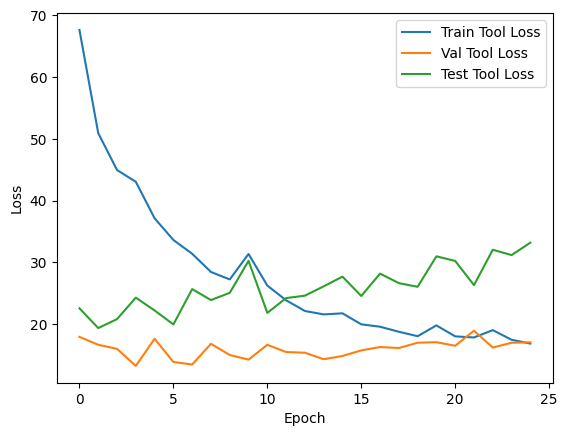

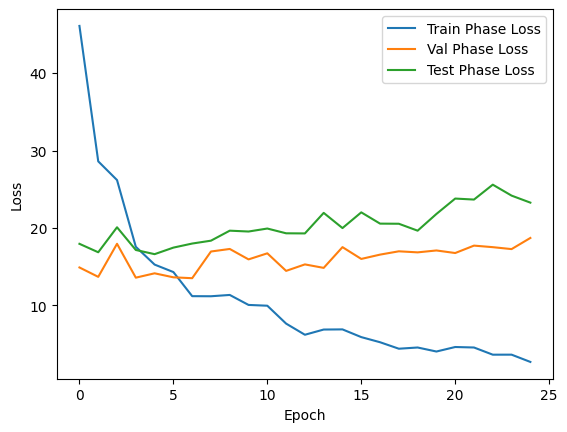

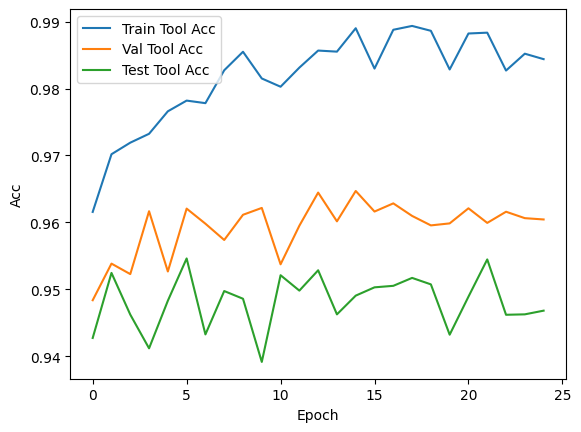

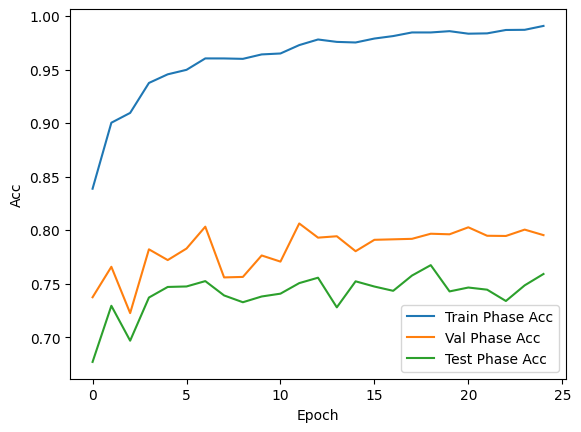

In [18]:
loss_data = pd.read_csv(project_path+'/two_networks_two_tasks/log/multi_tasks_cl_loss_log_with_alpha_2.csv')
# tool loss
train_tool_loss = loss_data['Train Tool Loss']
val_tool_loss = loss_data['Val Tool Loss']
test_tool_loss = loss_data['Test Tool Loss']
plt.plot(range(len(train_tool_loss)),train_tool_loss)
plt.plot(range(len(val_tool_loss)),val_tool_loss)
plt.plot(range(len(test_tool_loss)),test_tool_loss)
plt.legend(['Train Tool Loss','Val Tool Loss','Test Tool Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
# phase loss
train_phase_loss = loss_data['Train Phase Loss']
val_phase_loss = loss_data['Val Phase Loss']
test_phase_loss = loss_data['Test Phase Loss']
plt.plot(range(len(train_phase_loss)), train_phase_loss)
plt.plot(range(len(val_phase_loss)), val_phase_loss)
plt.plot(range(len(test_phase_loss)), test_phase_loss)
plt.legend(['Train Phase Loss', 'Val Phase Loss', 'Test Phase Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

acc_data = pd.read_csv(project_path+'/two_networks_two_tasks/log/multi_tasks_cl_acc_log_with_alpha_2.csv')
# tool acc
train_tool_acc = acc_data['Train Tool Acc']
val_tool_acc = acc_data['Val Tool Acc']
test_tool_acc = acc_data['Test Tool Acc']
plt.plot(range(len(train_tool_acc)), train_tool_acc)
plt.plot(range(len(val_tool_acc)), val_tool_acc)
plt.plot(range(len(test_tool_acc)), test_tool_acc)
plt.legend(['Train Tool Acc', 'Val Tool Acc', 'Test Tool Acc'])
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.show()
# phase acc
train_phase_acc = acc_data['Train Phase Acc']
val_phase_acc = acc_data['Val Phase Acc']
test_phase_acc = acc_data['Test Phase Acc']
plt.plot(range(len(train_phase_acc)), train_phase_acc)
plt.plot(range(len(val_phase_acc)), val_phase_acc)
plt.plot(range(len(test_phase_acc)), test_phase_acc)
plt.legend(['Train Phase Acc', 'Val Phase Acc', 'Test Phase Acc'])
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.show()